# 工作流程
* 載入需要的套件
* 從COCO的驗證資料集中找一張範例照片，並且網上下載，顯示照片
* 進行物件偵測，做方框標記
* 列出偵測出來的類別代碼，以及方框座標
* 列出代碼對應的物件
* 顯示辨識出來的圖形
* 展示骨骼標記
* 展示全景分割

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1 #pip 是一個 Python 安裝管理套件工具，將pycocotools和pyyaml套件安裝進來
import torch, torchvision #將torch, torchvision模組導入進來 torchvision是獨立於pytorch的關於圖像操作的一些方便工具庫 Torch是一個開源的機器學習庫
print(torch.__version__, torch.cuda.is_available()) #印出torch版本及torch cuda當前的狀態
!gcc --version #用gcc顯示當前版本
# opencv is pre-installed on colab

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6") #斷言測試torch.__version，版本為1.6
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html #將detectron2模組安裝進來

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
     |████████████████████████████████| 6.6MB 783kB/s 
     |████████████████████████████████| 2.2MB 3.3MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201020-cp36-none-any.whl size=44210 sha256=95f9accfddfb0bf338501215b1abe4ad32d578c6495606481af0ee23f82f5908
  Stored in directory: /root/.cache/pip/wheels/71/6c/b5/198f89a5c5f127327730248cc623e5a307ad11ed287c3fe391
Successfully built fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [ ]:
import detectron2 #導入detectron2模組
import cv2 #導入cv2模組
from detectron2 import model_zoo #嵌入外部資源，用impor將model_zoo模組導入進來
from detectron2.engine import DefaultPredictor #嵌入外部資源，用impor將DefaultPredictor模組導入進來
from detectron2.config import get_cfg #嵌入外部資源，用impor將get_cfg模組導入進來
from detectron2.utils.visualizer import Visualizer #嵌入外部資源，用impor將Visualizer模組導入進來
from detectron2.data import MetadataCatalog #嵌入外部資源，用impor將 MetadataCatalog模組導入進來
from matplotlib import pyplot as plt #嵌入外部資源，用impor將pyplot模組導入進來

--2020-10-26 06:54:45--  https://img.sportsv.net/img/article/cover/0/67200/fit-j60XkXF6RR-945x495.jpg
Resolving img.sportsv.net (img.sportsv.net)... 104.26.4.230, 172.67.69.171, 104.26.5.230, ...
Connecting to img.sportsv.net (img.sportsv.net)|104.26.4.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151578 (148K) [image/jpeg]
Saving to: ‘input.jpg’

input.jpg           100%[===================>] 148.03K   873KB/s    in 0.2s    

2020-10-26 06:54:47 (873 KB/s) - ‘input.jpg’ saved [151578/151578]



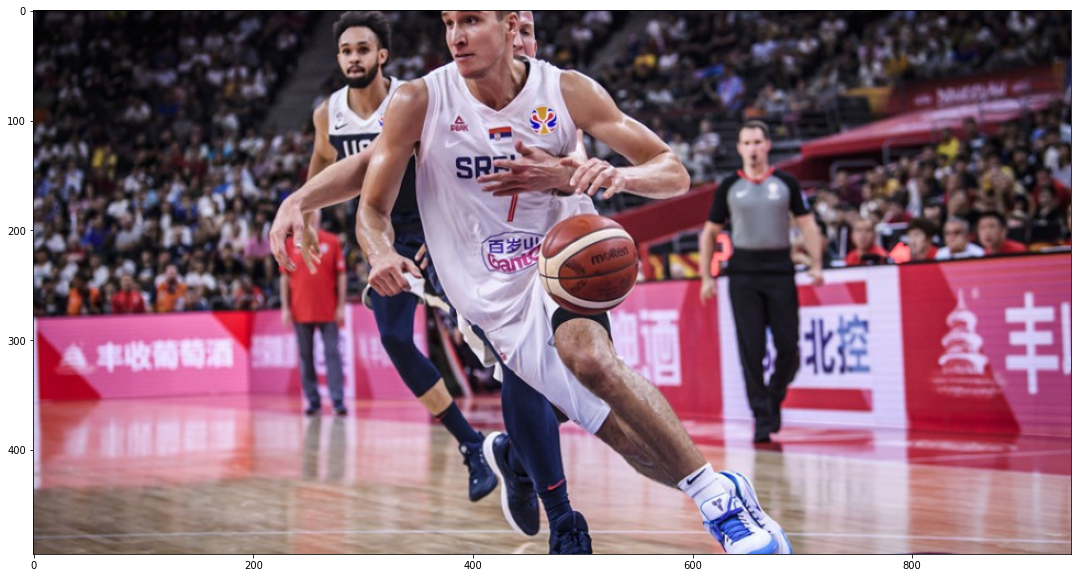

In [ ]:
!wget https://img.sportsv.net/img/article/cover/0/67200/fit-j60XkXF6RR-945x495.jpg -O input.jpg #用!wget取得當前圖片的位址，將資料寫入input.jpg中
im = cv2.imread("./fit-j60XkXF6RR-945x495.jpg") #宣告一個im用cv2.imread將圖片讀取進來
plt.figure(figsize=(20,10)) #figure繪製圖像，X軸=20 Y軸=10
plt.imshow(im[:,:,::-1]) #函數負責對圖像進行處理，並顯示其格式

# 程式流程
* 宣告設定檔物件
* 取得設定檔，指定需要的模型種類
* 設定辨識值的門檻
* 下載模型
* 宣告偵測器，並且進行偵測
* 展示類別代碼及標記值
* 利用內建Visualizer將偵測出的圖形顯示出來

In [ ]:
# 推論物體檢測模型
cfg = get_cfg() #獲取已經配置好默認參數的cfg
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")) #預訓練模型不需下載可直接使用Model zoo上的path來自動下載，下方的model_path使用的模型為ResNeXt-101 FPN
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # 設置此模型的閾值
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

# If your detectron2's version is not the most updated, please use direct link as followed, to get the link , please visit 
# https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md

# cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"

predictor = DefaultPredictor(cfg) #用predictor包装一下
outputs = predictor(im) #輸入圖片，輸出就是推理結果了


In [ ]:
#印出每一個實例預測的類別
print(outputs["instances"].pred_classes) 
print(outputs["instances"].pred_boxes) 

tensor([ 0,  0, 32,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Boxes(tensor([[253.3165,   0.0000, 689.9418, 491.2492],
        [599.9120, 101.3309, 722.0907, 396.7766],
        [459.9649, 187.9086, 551.8353, 275.9709],
        [216.4502, 179.2075, 287.4960, 369.5076],
        [821.2164, 188.0311, 866.0693, 228.3123],
        [226.1313,   7.1192, 420.4462, 442.4836],
        [780.6611, 191.7188, 826.8504, 230.2671],
        [738.6348, 189.2772, 782.3244, 233.1795],
        [855.6260, 183.1926, 906.8320, 224.4979],
        [ 70.6607, 238.5192, 104.7639, 275.9436]], device='cuda:0'))


In [ ]:
#顯示出實力預測類別的名稱
all_things = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
preds = [all_things[x] for x in outputs["instances"].pred_classes]
preds

['person',
 'person',
 'sports ball',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person']

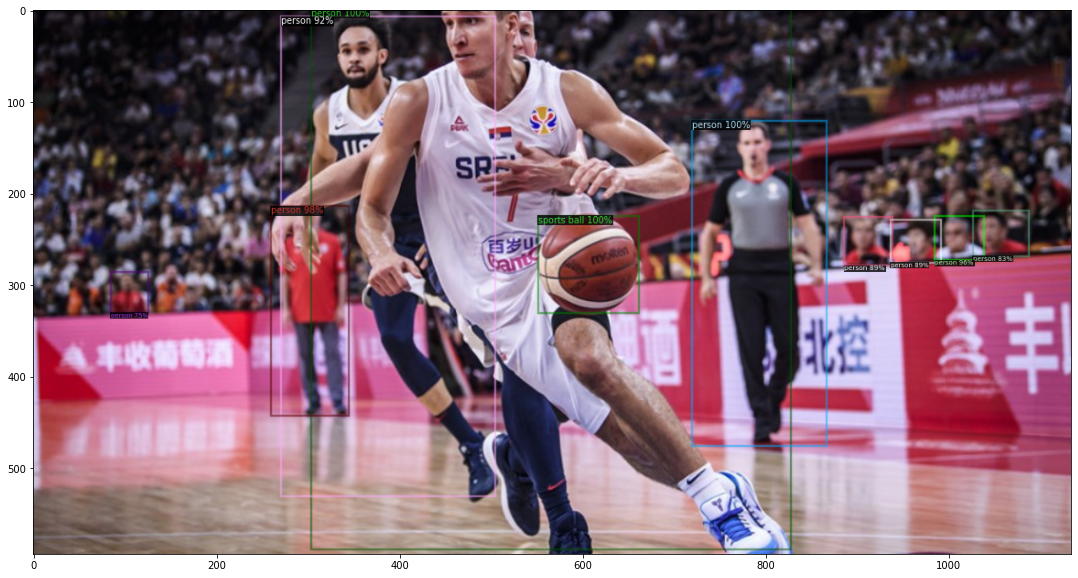

In [ ]:
#在原圖上畫出檢測結果
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(v.get_image())

['person', 'person', 'sports ball', 'person', 'person', 'person', 'person', 'person', 'person', 'person']


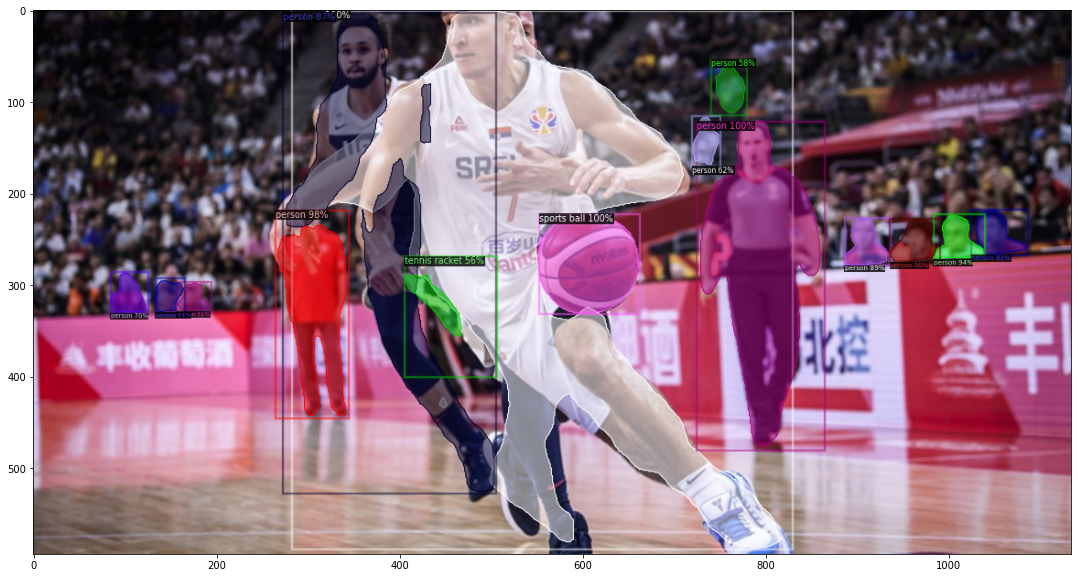

In [ ]:
#在原圖上畫出檢測結果，並顯示出是甚麼。以不同顏色區分
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # 設置此模型的閾值
# 從detectron2的模型動物園中找到模型。您也可以使用https：//dl.fbaipublicfiles ...網址
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
#cfg.MODEL.WEIGHTS = './model_final_f10217.pkl'
predictor = DefaultPredictor(cfg)
all_things = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
preds = [all_things[x] for x in outputs["instances"].pred_classes]
print(preds)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(v.get_image())

model_final_a6e10b.pkl: 237MB [00:08, 29.1MB/s]                           


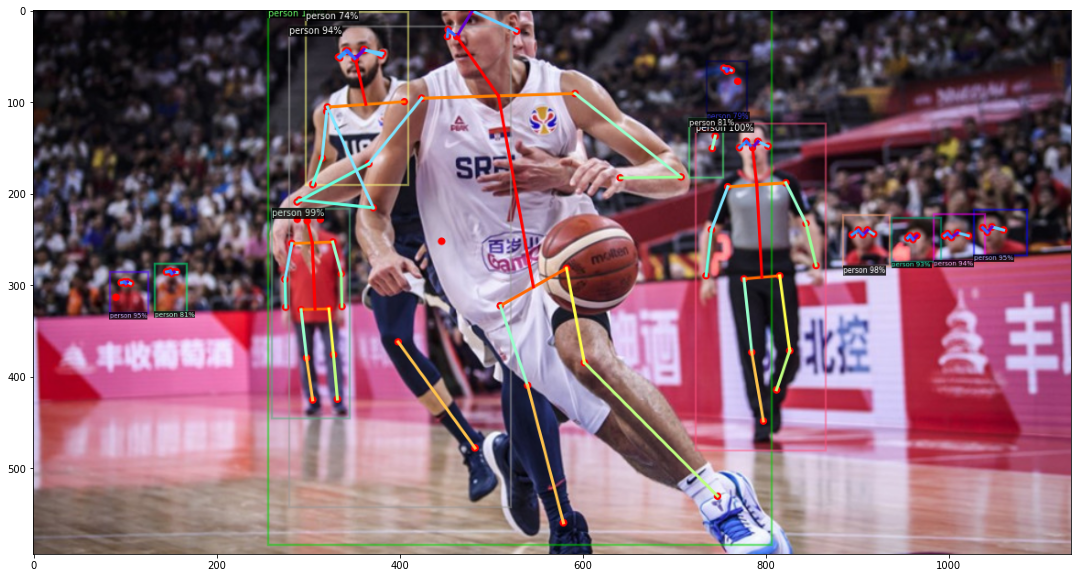

In [ ]:
# 推斷關鍵點檢測模型
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(v.get_image())

model_final_cafdb1.pkl: 261MB [00:09, 28.3MB/s]                           


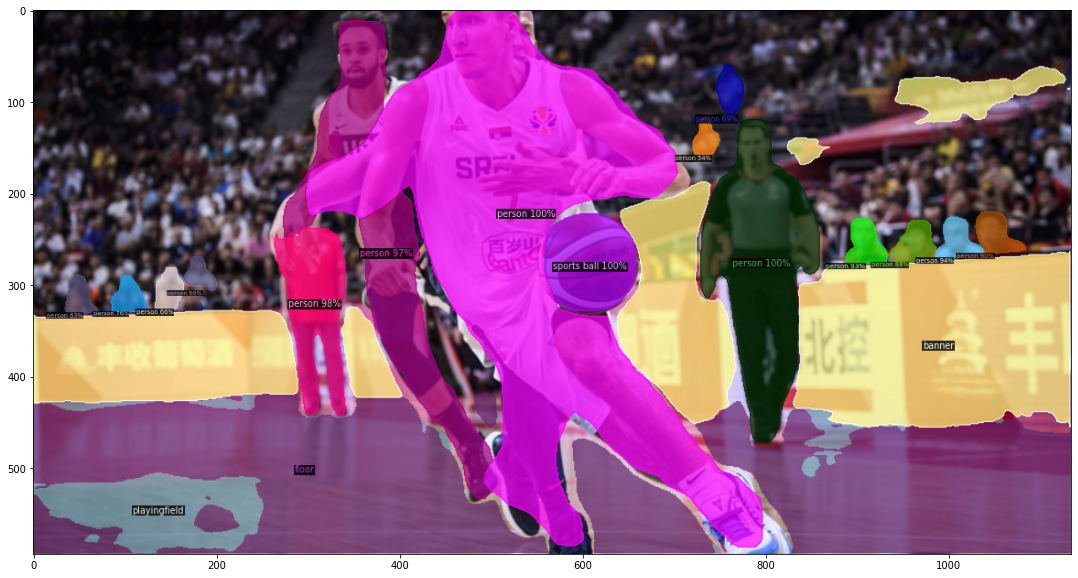

In [ ]:
# 使用全景分割模型進行推斷
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
plt.figure(figsize=(20,10))
plt.imshow(v.get_image())